In [1]:
import pandas as pd
import plotly.offline as pyo
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import catboost as cat
from sklearn import linear_model as lm
from sklearn.preprocessing import SplineTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
tb_orders_category=pd.read_csv('data/orders_category.csv')
tb_orders_category=tb_orders_category.drop_duplicates()
tb_orders_category[tb_orders_category['product_group_name']=='Garment Upper body']

,t_dat,product_group_name,Quantity,ValueTotal,sales_channel_id
1,2018-09-20,Garment Upper body,6489,182.484542,1
11,2018-09-20,Garment Upper body,16746,490.191831,2
52,2018-09-21,Garment Upper body,15817,481.372203,2
58,2018-09-21,Garment Upper body,7023,209.575797,1
107,2018-09-22,Garment Upper body,4626,140.211932,2
...,...,...,...,...,...
19493,2020-09-20,Garment Upper body,3558,108.049305,1
19511,2020-09-21,Garment Upper body,11526,450.979475,2
19520,2020-09-21,Garment Upper body,3570,102.551729,1
19536,2020-09-22,Garment Upper body,4844,139.455322,1


In [3]:
tb_top_category = (
    tb_orders_category.groupby("product_group_name")
    .agg(
        Quantity=pd.NamedAgg("Quantity", "sum"),
        ValueTotal=pd.NamedAgg("ValueTotal", "sum"),
    )
    .reset_index()
)
tb_top_category.sort_values(by='Quantity',ascending=False)

,product_group_name,Quantity,ValueTotal
7,Garment Upper body,12552755,338981.789203
6,Garment Lower body,7046054,231774.620034
5,Garment Full body,3552470,128478.941678
15,Swimwear,2579222,57628.166508
16,Underwear,2565858,54395.857458
0,Accessories,1599593,24893.822424
12,Shoes,745521,28888.356373
13,Socks & Tights,685712,7811.136525
11,Nightwear,348180,8852.815390
18,Unknown,97040,2598.734051


In [4]:
tb_orders_category["t_dat"] = pd.to_datetime(tb_orders_category["t_dat"])
tb_orders_category_top1=tb_orders_category[tb_orders_category['product_group_name']=='Garment Upper body']
tb_orders_category_top1=tb_orders_category_top1[tb_orders_category_top1['sales_channel_id']==1].reset_index()
tb_orders_category_top1=tb_orders_category_top1.drop('index',axis=1)
tb_orders_category_top1

,t_dat,product_group_name,Quantity,ValueTotal,sales_channel_id
0,2018-09-20,Garment Upper body,6489,182.484542,1
1,2018-09-21,Garment Upper body,7023,209.575797,1
2,2018-09-22,Garment Upper body,4071,126.129949,1
3,2018-09-23,Garment Upper body,3604,113.141695,1
4,2018-09-24,Garment Upper body,4563,139.429186,1
...,...,...,...,...,...
682,2020-09-18,Garment Upper body,6887,201.206390,1
683,2020-09-19,Garment Upper body,7832,230.801763,1
684,2020-09-20,Garment Upper body,3558,108.049305,1
685,2020-09-21,Garment Upper body,3570,102.551729,1


<AxesSubplot:xlabel='t_dat', ylabel='Quantity'>

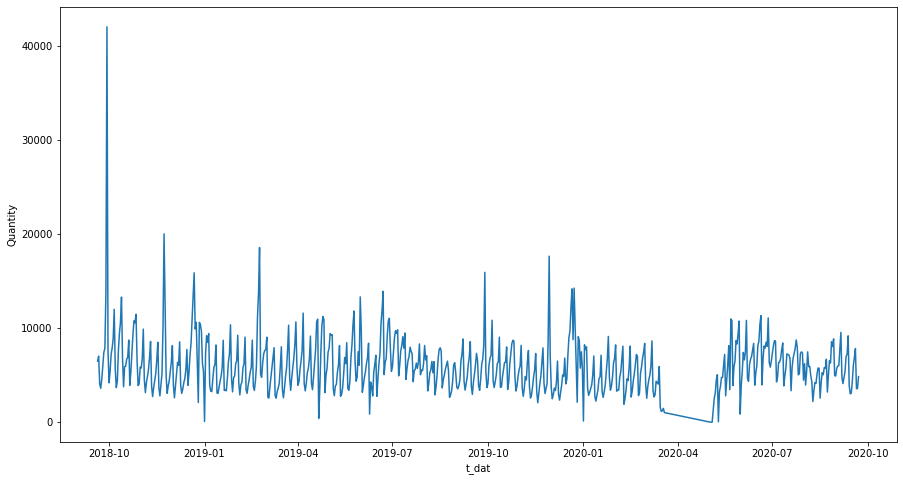

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=tb_orders_category_top1, x="t_dat", y="Quantity")

In [6]:
def split_store_ts(data, break_date):
    train_data = data[data["t_dat"] < break_date].copy()
    test_data = data[data["t_dat"] >= break_date].copy()
    return train_data, test_data

## Componente de Tendência (Trend)

In [7]:
tb_orders_category_top1["t_dias"] = (
    tb_orders_category_top1["t_dat"] - min(tb_orders_category_top1["t_dat"])
).dt.total_seconds() / (24 * 60 * 60)
tb_orders_category_top1.head()

,t_dat,product_group_name,Quantity,ValueTotal,sales_channel_id,t_dias
0,2018-09-20,Garment Upper body,6489,182.484542,1,0.0
1,2018-09-21,Garment Upper body,7023,209.575797,1,1.0
2,2018-09-22,Garment Upper body,4071,126.129949,1,2.0
3,2018-09-23,Garment Upper body,3604,113.141695,1,3.0
4,2018-09-24,Garment Upper body,4563,139.429186,1,4.0


In [8]:
train_data, test_data = split_store_ts(tb_orders_category_top1, "2020-09-01")

In [9]:
trend_fit = lm.LinearRegression()

trend_fit.fit(train_data[["t_dias"]], train_data["Quantity"])

LinearRegression()

In [10]:
trend_fit.coef_

array([-1.72476949])

In [11]:
tb_orders_category_top1["pred_trend_linear"] = trend_fit.predict(tb_orders_category_top1[["t_dias"]])

Text(0.5, 0.95, 'Evolução da Quantidade vendida por Data')

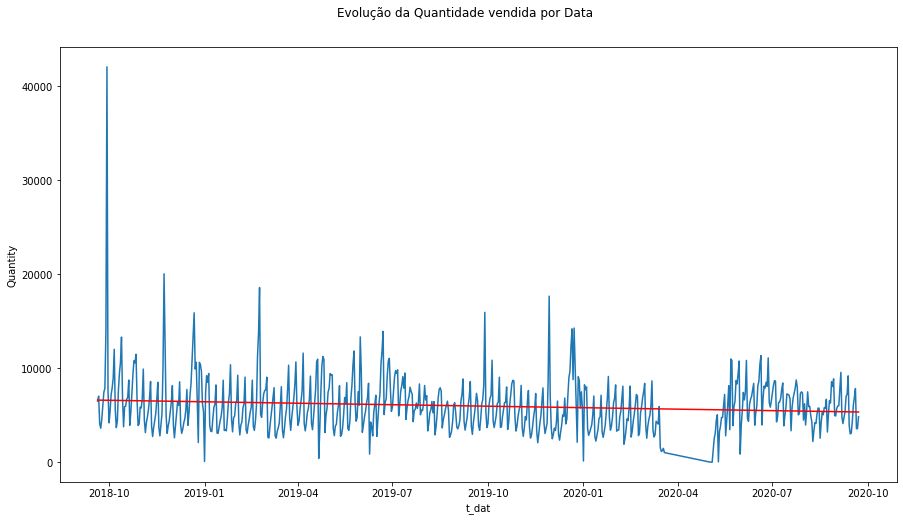

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=tb_orders_category_top1, x="t_dat", y="Quantity")
sns.lineplot(data=tb_orders_category_top1, x="t_dat", y="pred_trend_linear", color="red")
fig.suptitle("Evolução da Quantidade vendida por Data", y=0.95)

## Componente Cíclico (Cycle)

### Tendência Polinomial

In [13]:
from sklearn.preprocessing import PolynomialFeatures

In [14]:
poly_trans = PolynomialFeatures(degree=2)
poly_trans.fit(train_data[["t_dias"]])

PolynomialFeatures()

In [15]:
poly_trans.n_output_features_

3

In [16]:
poly_names = ["P" + str(i) for i in range(poly_trans.n_output_features_)]
pd.DataFrame(
            poly_trans.transform(tb_orders_category_top1[["t_dias"]]),
            columns=poly_names,
        )

,P0,P1,P2
0,1.0,0.0,0.0
1,1.0,1.0,1.0
2,1.0,2.0,4.0
3,1.0,3.0,9.0
4,1.0,4.0,16.0
...,...,...,...
682,1.0,729.0,531441.0
683,1.0,730.0,532900.0
684,1.0,731.0,534361.0
685,1.0,732.0,535824.0


In [17]:
poly_trans.transform(tb_orders_category_top1[["t_dias"]])

array([[1.00000e+00, 0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 2.00000e+00, 4.00000e+00],
       ...,
       [1.00000e+00, 7.31000e+02, 5.34361e+05],
       [1.00000e+00, 7.32000e+02, 5.35824e+05],
       [1.00000e+00, 7.33000e+02, 5.37289e+05]])

In [18]:
poly_names = ["P" + str(i) for i in range(poly_trans.n_output_features_)]
tb_orders_category_top1 = pd.concat(
    [
        tb_orders_category_top1,
        pd.DataFrame(
            poly_trans.transform(tb_orders_category_top1[["t_dias"]]),
            columns=poly_names,
        ),
    ],
    axis=1,
)
tb_orders_category_top1.head()

,t_dat,product_group_name,Quantity,ValueTotal,sales_channel_id,t_dias,pred_trend_linear,P0,P1,P2
0,2018-09-20,Garment Upper body,6489,182.484542,1,0.0,6601.076933,1.0,0.0,0.0
1,2018-09-21,Garment Upper body,7023,209.575797,1,1.0,6599.352163,1.0,1.0,1.0
2,2018-09-22,Garment Upper body,4071,126.129949,1,2.0,6597.627394,1.0,2.0,4.0
3,2018-09-23,Garment Upper body,3604,113.141695,1,3.0,6595.902624,1.0,3.0,9.0
4,2018-09-24,Garment Upper body,4563,139.429186,1,4.0,6594.177855,1.0,4.0,16.0


Text(0.5, 1.05, 'Evolução da Quantidade vendida por Data\ncom Tendências Linear e Polinomial de grau 2')

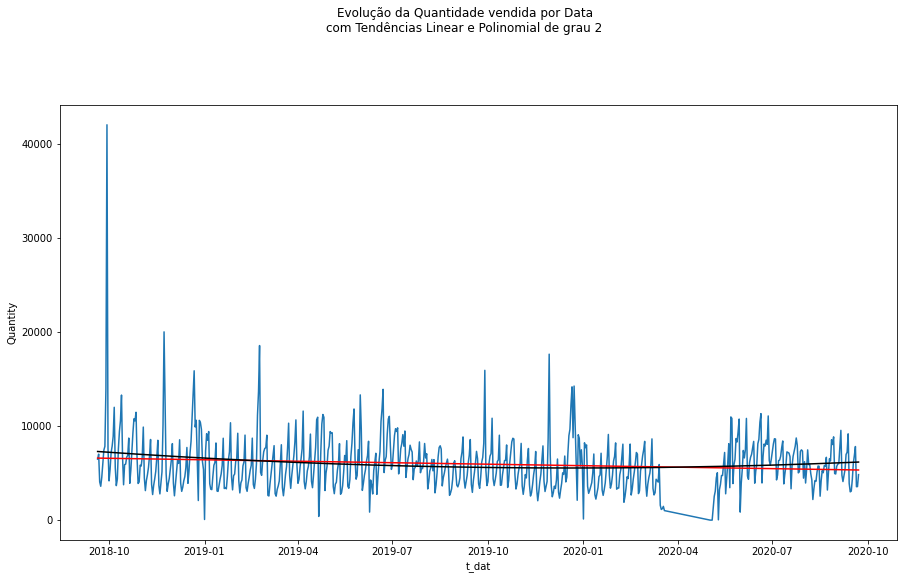

In [19]:
train_data, test_data = split_store_ts(tb_orders_category_top1, "2020-09-01")

poly_trend_fit = lm.LinearRegression()
poly_trend_fit.fit(train_data[poly_names], train_data["Quantity"])



tb_orders_category_top1["pred_trend_poly"] = poly_trend_fit.predict(tb_orders_category_top1[poly_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=tb_orders_category_top1, x="t_dat", y="Quantity")
sns.lineplot(data=tb_orders_category_top1, x="t_dat", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_orders_category_top1, x="t_dat", y="pred_trend_poly", color="black")
fig.suptitle(
    f"Evolução da Quantidade vendida por Data\ncom Tendências Linear e Polinomial de grau {poly_trans.degree}",
    y=1.05,
)

In [20]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_poly"] = poly_trend_fit.predict(test_data[poly_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["Quantity"], test_data["pred_trend_linear"])
)
rmse_poly = np.sqrt(
    mean_squared_error(test_data["Quantity"], test_data["pred_trend_poly"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Poly.: {round(rmse_poly, 2)}")

Trend Lin.: 1873.2
Trend Poly.: 1918.21


### B-Splines

In [21]:
spl_trans = SplineTransformer(n_knots=24, extrapolation="constant")
spl_trans.fit(train_data[["t_dias"]])

SplineTransformer(n_knots=24)

In [22]:
spl_names = ["S" + str(i) for i in range(spl_trans.n_features_out_)]
spl_names

['S0',
 'S1',
 'S2',
 'S3',
 'S4',
 'S5',
 'S6',
 'S7',
 'S8',
 'S9',
 'S10',
 'S11',
 'S12',
 'S13',
 'S14',
 'S15',
 'S16',
 'S17',
 'S18',
 'S19',
 'S20',
 'S21',
 'S22',
 'S23',
 'S24',
 'S25']

In [23]:
pd.DataFrame(spl_trans.transform(tb_orders_category_top1[["t_dias"]]), columns=spl_names)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25
0,0.166667,0.666667,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.151010,0.665637,0.183347,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.136366,0.662616,0.200973,0.000045,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.122700,0.657706,0.219442,0.000152,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.109980,0.651007,0.238653,0.000361,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
683,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
684,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
685,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667


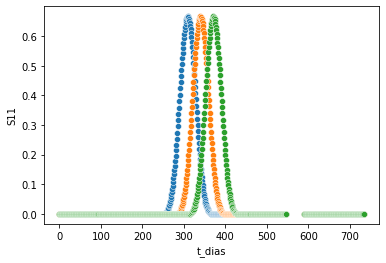

In [24]:
tb_orders_category_top1_b = pd.concat(
    [
        tb_orders_category_top1,
        pd.DataFrame(
            spl_trans.transform(tb_orders_category_top1[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)
tb_orders_category_top1_b.head()
sns.scatterplot(data = tb_orders_category_top1_b, x = 't_dias', y = 'S11');
sns.scatterplot(data = tb_orders_category_top1_b, x = 't_dias', y = 'S12');
sns.scatterplot(data = tb_orders_category_top1_b, x = 't_dias', y = 'S13');

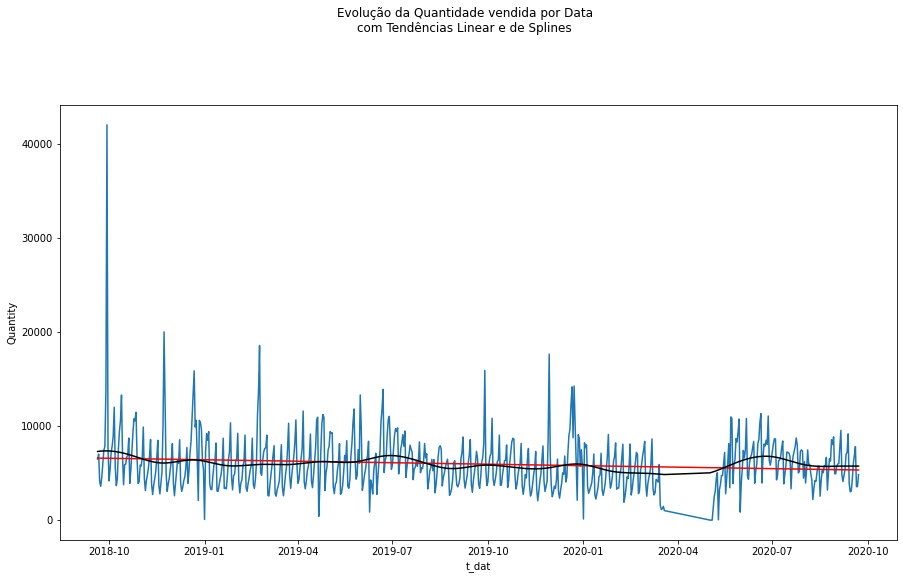

In [25]:
train_data, test_data = split_store_ts(tb_orders_category_top1_b, "2020-09-01")

spline_fit = lm.RidgeCV(cv = 5)
spline_fit.fit(train_data[spl_names], train_data["Quantity"])

tb_orders_category_top1_b["pred_spline"] = spline_fit.predict(tb_orders_category_top1_b[spl_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=tb_orders_category_top1_b, x="t_dat", y="Quantity")
sns.lineplot(data=tb_orders_category_top1_b, x="t_dat", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_orders_category_top1_b, x="t_dat", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Quantidade vendida por Data\ncom Tendências Linear e de Splines",
    y=1.05,
);


In [26]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["Quantity"], test_data["pred_trend_linear"])
)
rmse_spl = np.sqrt(
    mean_squared_error(test_data["Quantity"], test_data["pred_trend_spline"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline.: {round(rmse_spl, 2)}")

Trend Lin.: 1873.2
Trend Spline.: 1853.03


## Componente Sazonal

### Variáveis Sazonais Dummy

In [27]:
tb_orders_category_top1_b["mes"] = tb_orders_category_top1_b["t_dat"].dt.month.astype(str)
tb_orders_category_top1_b["dia_semana"] = tb_orders_category_top1_b["t_dat"].dt.weekday.astype(str)

In [28]:
tb_orders_category_top1_b[["mes", "dia_semana"]]

,mes,dia_semana
0,9,3
1,9,4
2,9,5
3,9,6
4,9,0
...,...,...
682,9,4
683,9,5
684,9,6
685,9,0


In [29]:
ohe_fit = OneHotEncoder(drop="first", sparse=False)
ohe_fit.fit(tb_orders_category_top1_b[["mes", "dia_semana"]])

tb_orders_category_top1_d = pd.concat(
    [
        tb_orders_category_top1_b,
        pd.DataFrame(
            ohe_fit.transform(tb_orders_category_top1_b[["mes", "dia_semana"]]),
            columns=ohe_fit.get_feature_names_out(),
        ),
    ],
    axis=1,
)


In [30]:
tb_orders_category_top1_d.head()

,t_dat,product_group_name,Quantity,ValueTotal,sales_channel_id,t_dias,pred_trend_linear,P0,P1,P2,...,mes_6,mes_7,mes_8,mes_9,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
0,2018-09-20,Garment Upper body,6489,182.484542,1,0.0,6601.076933,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2018-09-21,Garment Upper body,7023,209.575797,1,1.0,6599.352163,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2018-09-22,Garment Upper body,4071,126.129949,1,2.0,6597.627394,1.0,2.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2018-09-23,Garment Upper body,3604,113.141695,1,3.0,6595.902624,1.0,3.0,9.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2018-09-24,Garment Upper body,4563,139.429186,1,4.0,6594.177855,1.0,4.0,16.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.05, 'Evolução da Quantidade vendida por Data\ncom Tendências Linear e Índices Sazonais')

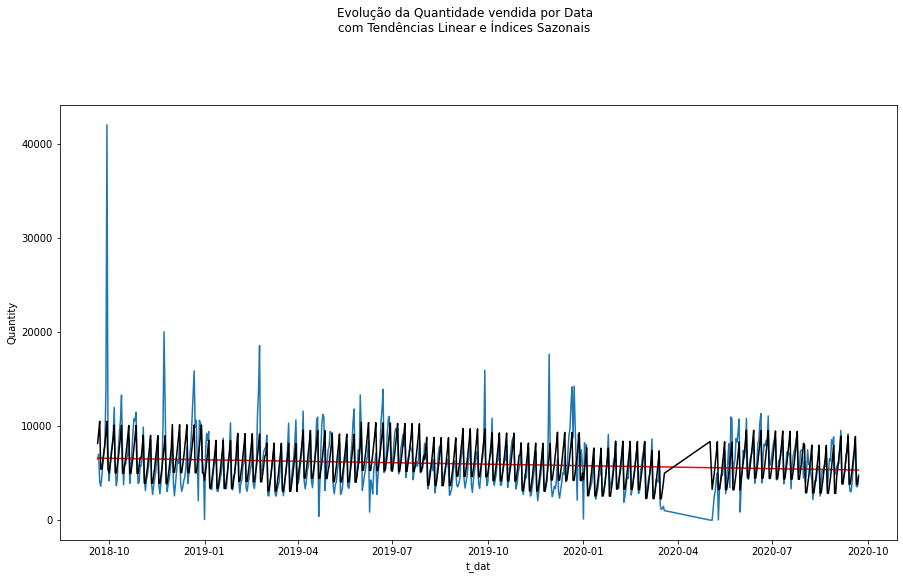

In [31]:
train_data, test_data = split_store_ts(tb_orders_category_top1_d, "2020-09-01")
dummy_names = list(ohe_fit.get_feature_names_out())

var_names = ["t_dias"] + dummy_names

season_trend_fit = lm.LinearRegression()
season_trend_fit.fit(train_data[var_names], train_data["Quantity"])

tb_orders_category_top1_d["pred_trend_season"] = season_trend_fit.predict(
    tb_orders_category_top1_d[var_names]
)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=tb_orders_category_top1_d, x="t_dat", y="Quantity")
sns.lineplot(data=tb_orders_category_top1_d, x="t_dat", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_orders_category_top1_d, x="t_dat", y="pred_trend_season", color="black")
fig.suptitle(
    f"Evolução da Quantidade vendida por Data\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)

Text(0.5, 1.05, 'Evolução da demanda no perido de teste\ncom Tendências Linear e Índices Sazonais')

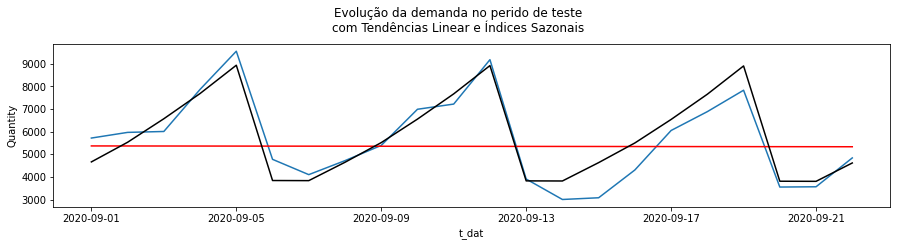

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_orders_category_top1_d[tb_orders_category_top1_d['t_dat'] >= "2020-09-01"], x="t_dat", y="Quantity")
sns.lineplot(data=tb_orders_category_top1_d[tb_orders_category_top1_d['t_dat'] >= "2020-09-01"], x="t_dat", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_orders_category_top1_d[tb_orders_category_top1_d['t_dat'] >= "2020-09-01"], x="t_dat", y="pred_trend_season", color="black")
fig.suptitle(
    f"Evolução da demanda no perido de teste\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)

In [33]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_season"] = season_trend_fit.predict(test_data[var_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["Quantity"], test_data["pred_trend_linear"])
)
rmse_cycle = np.sqrt(
    mean_squared_error(test_data["Quantity"], test_data["pred_trend_season"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend + Season: {round(rmse_cycle, 2)}")

Trend Lin.: 1873.2
Trend + Season: 677.86


In [47]:
tb_orders_category_top1_d[tb_orders_category_top1_d['t_dat'] >= "2020-03-19"]

,t_dat,product_group_name,Quantity,ValueTotal,sales_channel_id,t_dias,pred_trend_linear,P0,P1,P2,...,mes_8,mes_9,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,pred_trend_season,pred_boosting
544,2020-03-19,Garment Upper body,1016,23.611542,1,546.0,5659.352792,1.0,546.0,298116.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4993.544956,3530.307062
545,2020-05-02,Garment Upper body,4,0.149102,1,590.0,5583.462934,1.0,590.0,348100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8367.897449,4282.425302
546,2020-05-04,Garment Upper body,2,0.024373,1,592.0,5580.013395,1.0,592.0,350464.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3273.467705,2062.386744
547,2020-05-06,Garment Upper body,2527,53.934322,1,594.0,5576.563856,1.0,594.0,352836.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4952.138835,3038.942884
548,2020-05-07,Garment Upper body,3084,64.833322,1,595.0,5574.839087,1.0,595.0,354025.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5989.863706,3682.129546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,2020-09-18,Garment Upper body,6887,201.206390,1,729.0,5343.719975,1.0,729.0,531441.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,7655.861904,6905.701027
683,2020-09-19,Garment Upper body,7832,230.801763,1,730.0,5341.995206,1.0,730.0,532900.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8904.354574,8069.657036
684,2020-09-20,Garment Upper body,3558,108.049305,1,731.0,5340.270436,1.0,731.0,534361.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3815.023755,4284.944941
685,2020-09-21,Garment Upper body,3570,102.551729,1,732.0,5338.545667,1.0,732.0,535824.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3809.924831,5086.172611


Text(0.5, 1.05, 'Evolução da demanda no perido de teste\ncom Tendências Linear e Índices Sazonais')

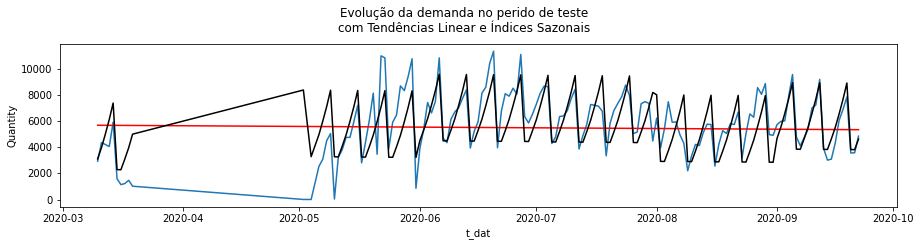

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_orders_category_top1_d[tb_orders_category_top1_d['t_dat'] >= "2020-03-10"], x="t_dat", y="Quantity")
sns.lineplot(data=tb_orders_category_top1_d[tb_orders_category_top1_d['t_dat'] >= "2020-03-10"], x="t_dat", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_orders_category_top1_d[tb_orders_category_top1_d['t_dat'] >= "2020-03-10"], x="t_dat", y="pred_trend_season", color="black")
fig.suptitle(
    f"Evolução da demanda no perido de teste\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)

# Criando nosso modelo final

In [35]:
final_list = spl_names + dummy_names + ["t_dias"]
X_train = train_data[final_list]
X_test = test_data[final_list]
y_train = train_data["Quantity"]
y_test = test_data["Quantity"]

scaler = StandardScaler()
scaler.fit(X_train)

cat_fit = cat.CatBoostRegressor(iterations=20000, depth=9, od_type="Iter", 
                                od_wait=1500, verbose = False)
cat_fit.fit(
    scaler.transform(X_train), y_train, eval_set=(scaler.transform(X_test), y_test)
)

Trend Lin.: 1873.2
Trend Spline.: 1853.03
Trend+Sazonal: 677.86
Trend+Spline+Seazonal: 962.86


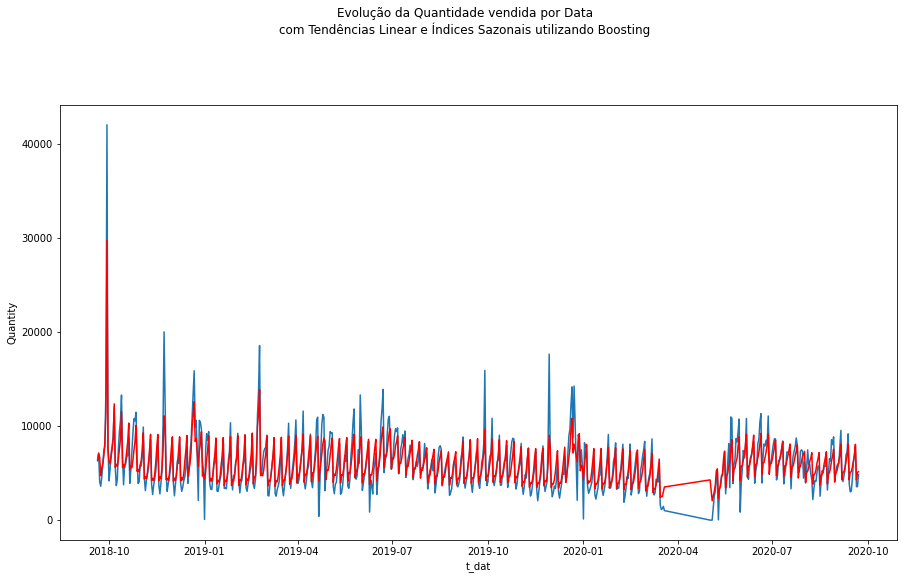

In [36]:
tb_orders_category_top1_d["pred_boosting"] = cat_fit.predict(
    scaler.transform(tb_orders_category_top1_d[final_list])
)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=tb_orders_category_top1_d, x="t_dat", y="Quantity")
sns.lineplot(data=tb_orders_category_top1_d, x="t_dat", y="pred_boosting", color="red")
fig.suptitle(
    f"Evolução da Quantidade vendida por Data\ncom Tendências Linear e Índices Sazonais utilizando Boosting",
    y=1.05,
);

pred_boosting = cat_fit.predict(
    scaler.transform(X_test[final_list])
)
rmse_cat = np.sqrt(
    mean_squared_error(y_test, pred_boosting)
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline.: {round(rmse_spl, 2)}")
print(f'Trend+Sazonal: {round(rmse_cycle, 2)}')
print(f"Trend+Spline+Seazonal: {round(rmse_cat, 2)}")


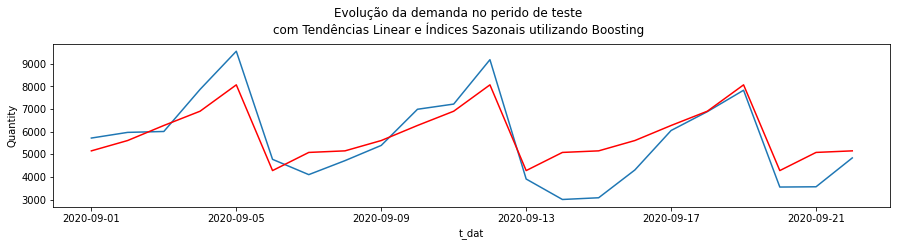

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_orders_category_top1_d[tb_orders_category_top1_d['t_dat'] >= "2020-09-01"], x="t_dat", y="Quantity")
sns.lineplot(data=tb_orders_category_top1_d[tb_orders_category_top1_d['t_dat'] >= "2020-09-01"], x="t_dat", y="pred_boosting", color="red")
fig.suptitle(
    f"Evolução da demanda no perido de teste\ncom Tendências Linear e Índices Sazonais utilizando Boosting",
    y=1.05,
);